# **Forecasting Paragorn Corps Sale Final Project** 💎

## 1. Introduction 👋

*   Nama: Karel Gideon Anugrah Hutajulu
*   Batch: FTDS HCK-004


## 2. Deployment Link 🔗

**Hugging Face Deployment Link:** https://huggingface.co/spaces/karelgideon/talent-fair-h8-karel

## 3. Working Area ⛑

### A. IMPORT LIBRARIES 💽

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import pickle

from statsmodels.tsa.stattools import adfuller

#Time Series Model libraries
import xgboost as xgb
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error as mape

#Attach images to the google notebook
from IPython.display import Image


### B. DATA LOADING 💽

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First of all i upload the dataset and display the head and tail to get a deeper understanding of the data im working with.

In [5]:
df1 = pd.read_csv('/content/drive/MyDrive/sample_dataset_timeseries_noarea.csv')
df1.head()

,week_number,week_start_date,week_end_date,product_item,quantity
0,2021-52,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41
1,2021-52,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430
2,2021-52,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4
3,2021-52,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148
4,2021-52,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119


In [6]:
df1.tail()

,week_number,week_start_date,week_end_date,product_item,quantity
102728,2023-14,2023-04-03,2023-04-09,ff3890faa80ff425ae906e27bbc50bc6,907
102729,2023-14,2023-04-03,2023-04-09,ff4b0f3b9c78c91510a4e3920fbc5090,81
102730,2023-14,2023-04-03,2023-04-09,ff9d05a4d6f922b3ab1653f58165b8ce,16
102731,2023-14,2023-04-03,2023-04-09,ffbd6f1d884056a4f622d54ae79e5a14,42920
102732,2023-14,2023-04-03,2023-04-09,fff18f7c705e729746515e2053dee64b,53


**Observation:**

Looks like the data im working with is grouped by perweek. Since product_item is a free variable we will ignore this column.

The level of aggregation or granularity (weekly) may result in the loss of fine-grained patterns, making it harder to identify seasonality or trend.

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102733 entries, 0 to 102732
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   week_number      102733 non-null  object
 1   week_start_date  102733 non-null  object
 2   week_end_date    102733 non-null  object
 3   product_item     102731 non-null  object
 4   quantity         102733 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.9+ MB


In [8]:
df1.shape

(102733, 5)

### C. DATA CLEANING

**1. Checking duplicates**

In [9]:
df1.duplicated().sum()

0

**Observation:**
There are no duplicates in this dataset

**2. Checking missing values**

In [10]:
df1.isna().sum()

week_number        0
week_start_date    0
week_end_date      0
product_item       2
quantity           0
dtype: int64

**Observation:**
There are 2 missing values from the `product_item` column. Lets see what the 2 missing row looks like.

In [11]:
# Filter rows with missing values in any column
result = df1[df1.isna().any(axis=1)]

result

,week_number,week_start_date,week_end_date,product_item,quantity
18048,2022-12,2022-03-21,2022-03-27,NaN,119
19536,2022-13,2022-03-28,2022-04-03,NaN,147


**Observation:**
As we can see, the 2 missing rows have low quantities. Since the quantity is low and the product_item is a free variable, we will not remove it.

### D. Data Visualization and EDA 🎁

**1. Understanding the date columns**

To begin i want to check the datatypes of the data. During EDA it is easier to work with time that is in the datetime format

In [12]:
df1.dtypes

week_number        object
week_start_date    object
week_end_date      object
product_item       object
quantity            int64
dtype: object

`week_start_date` and `week_end_date` are object columns. We will convert them to date time columns to make it easier for us to work with.

In [13]:
# Convert "week_start_date" and "week_end_date" columns to datetime objects
df1['week_start_date'] = pd.to_datetime(df1['week_start_date'])
df1['week_end_date'] = pd.to_datetime(df1['week_end_date'])

Next I want to make sure that every week is consistent for all the data. I am expecting the result of `.mean()` to have a whole number value and the result of the value counts to have the same number as the df1 shape.

In [14]:
# Calculate the day difference between week_start_date and week_end_date and calculate the average
avg_day_difference = (df1['week_end_date'] - df1['week_start_date']).dt.days.mean()

print("Average day difference between week start and week end:", avg_day_difference, "days")


Average day difference between week start and week end: 6.0 days


In [15]:
(df1['week_end_date'] - df1['week_start_date']).value_counts()

6 days    102733
dtype: int64

**Observation:** Looks like every row is consisten in representing a week. The average shows 6 days because it represent 6 nights and 7 days.

Lastly I want to see if the data is ordered in order of time. I will compare the oldest and newest data with the dataframe when displaying the `.head` and `.tail`.



In [16]:
# Find the lowest value of 'week_start_date'
lowest_start_date = df1['week_start_date'].min()

# Find the latest value of 'week_end_date'
latest_end_date = df1['week_end_date'].max()

print("Lowest 'week_start_date': ", lowest_start_date)
print("Latest 'week_end_date': ", latest_end_date)

Lowest 'week_start_date':  2021-12-27 00:00:00
Latest 'week_end_date':  2023-04-09 00:00:00


**Observation:** As we can see the dates match and we can safely assume that the dataframe is in order from oldest to newest

**2. Understanding the product_id column**

In [17]:
# Print count of unique values in "product_item" column
unique_product_items = df1["product_item"].nunique()
print("Count of unique product items:", unique_product_items)

Count of unique product items: 2309


There are a lot of different product variations `2309` products. Since the data has `10,000+` rows of data, we know that there are repeating orders of the products.

It is possible that the `different product types could have an impact on the total sales in the next week`. So, including contribution of some of them could be beneficial.

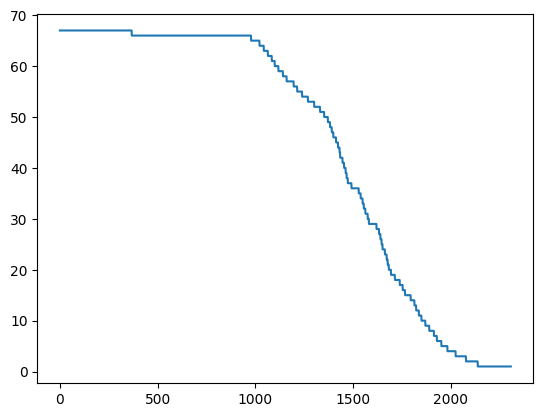

In [18]:
plt.plot(df1['product_item'].value_counts().values)

**Observation:** We have a `total of 67 week`s. The above plot shows that there are `around 300-400 product types that are ordered in every week`. So, sale quantity of these products can be included as features for prediction on total sales quantity.

Next i want to visualize the distribution of quantity between different products using a pie chart

<ipython-input-19-fce76a19e78e>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df1.groupby('product_item').sum()


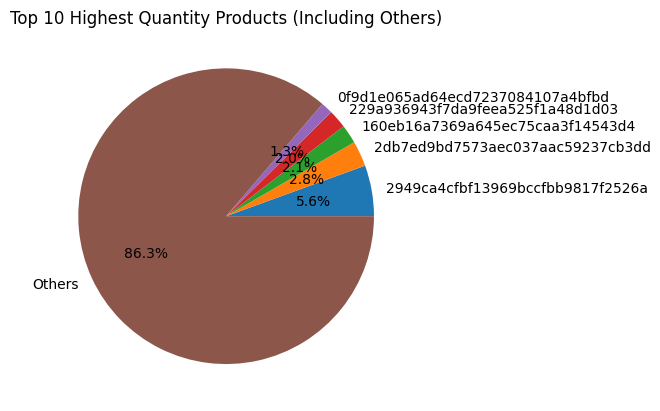

In [19]:
# Groupby product_item and sum the quantity
grouped_df = df1.groupby('product_item').sum()
grouped_df = grouped_df.sort_values(by='quantity', ascending=False)

# Get the top 10 products
top_5_df = grouped_df.head(5)

# Get the sum of quantity for products not in the top 10
others_quantity = grouped_df[~grouped_df.index.isin(top_5_df.index)]['quantity'].sum()

# Create a new dataframe for the pie chart
pie_df = top_5_df.copy()
pie_df.loc['Others'] = others_quantity

# Plot a pie chart
plt.pie(pie_df['quantity'], labels=pie_df.index, autopct='%1.1f%%')
plt.title('Top 10 Highest Quantity Products (Including Others)')
plt.show()

**Observation:** As we can see most of the products are sold in low quantities. The top 10 selling products only makes up for less than 15% of the total sales.

Lets see how the sales differentiate from order to order, are most of the orders from the same size (big batches of order) or from different sizes. Ex: Some small batch, some big batch. 

We will do this by plotting a boxplot.

<ipython-input-20-516b048b3925>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df1.groupby('product_item').sum()


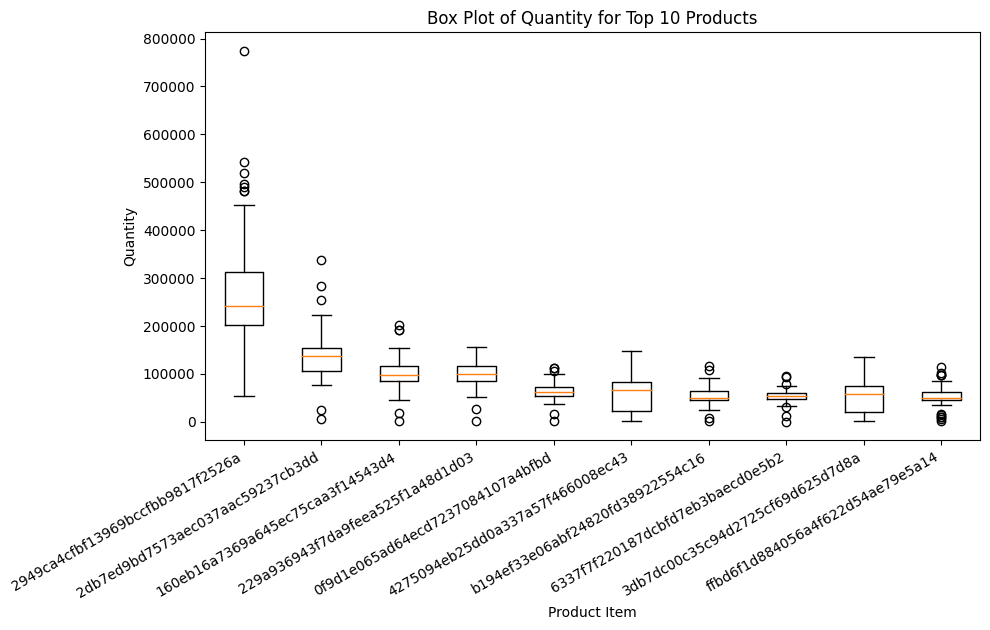

In [20]:

# Groupby product_item and sum the quantity
grouped_df = df1.groupby('product_item').sum()
grouped_df = grouped_df.sort_values(by='quantity', ascending=False)

# Get the top 10 products
top_10_df = grouped_df.head(10)

# Filter the original dataframe to include only the top 10 products
df_top_10 = df1[df1['product_item'].isin(top_10_df.index)]

# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot([df_top_10[df_top_10['product_item'] == product]['quantity'] for product in top_10_df.index],
            labels=top_10_df.index)
plt.title('Box Plot of Quantity for Top 10 Products')
plt.xlabel('Product Item')
plt.ylabel('Quantity')
plt.gcf().autofmt_xdate()
plt.show()


**Observation:** As we can see for the top 10 products. Most of the products are `varied in order sizes`. Especially for the biggest order. It is` hard to identify what type of outlier` this is because of the `lack of context for the data.`

Lastly, I want to see the quantity distribution for all products in the 67 weeks provided by the data.  As we can see, the average quantity of sales each week is greatly influenced by these huge batch of orders.

This happens for almost all the weeks `except for Week 21 of 2022`. During that week there are no large orders. This can cause the time series graph to significantly fall down.

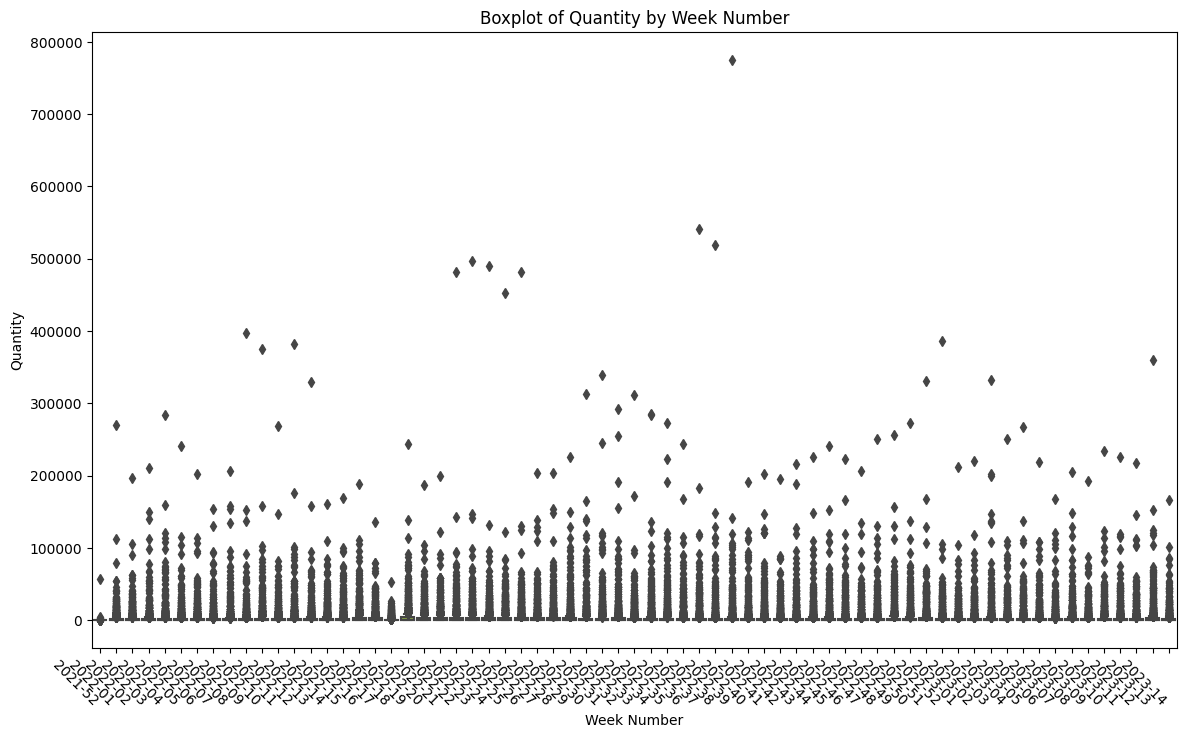

In [21]:
# Set figure size
plt.figure(figsize=(14, 8))

# Plot boxplot for each week_number
sns.boxplot(x='week_number', y='quantity', data=df1)
plt.xlabel('Week Number')
plt.xticks(rotation=-45, ha='right', fontsize=10)  # Rotate x-axis labels by 45 degrees, align to right, and set font size
plt.ylabel('Quantity')
plt.title('Boxplot of Quantity by Week Number')

plt.show()

### E. Data Preprocessing 🍳

**1. Aggregating the data on a weekly basis**

I start by making sure that the week_number and week_start/end_date matches.

In [22]:
df1['week_number'].value_counts()

2022-31    1831
2022-33    1712
2022-36    1680
2022-39    1660
2022-34    1659
           ... 
2022-10    1457
2022-08    1444
2022-09    1417
2022-18    1352
2021-52     450
Name: week_number, Length: 67, dtype: int64

In [23]:
df1['week_start_date'].value_counts()

2022-08-01    1831
2022-08-15    1712
2022-09-05    1680
2022-09-26    1660
2022-08-22    1659
              ... 
2022-03-07    1457
2022-02-21    1444
2022-02-28    1417
2022-05-02    1352
2021-12-27     450
Name: week_start_date, Length: 67, dtype: int64

In [24]:
df1['week_end_date'].value_counts()

2022-08-07    1831
2022-08-21    1712
2022-09-11    1680
2022-10-02    1660
2022-08-28    1659
              ... 
2022-03-13    1457
2022-02-27    1444
2022-03-06    1417
2022-05-08    1352
2022-01-02     450
Name: week_end_date, Length: 67, dtype: int64

Then i create a new dataframe named `df2` that groups by the weeknumber and  use an aggregation function that is applied to calculates the sum of the numeric columns for each quantity per week.

In [25]:
df2 = df1.groupby('week_start_date').sum()

<ipython-input-25-005999a081e9>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df1.groupby('week_start_date').sum()


In [26]:
df2

,quantity
week_start_date,
2021-12-27,128808
2022-01-03,3839557
2022-01-10,4138934
2022-01-17,4149077
2022-01-24,4824273
...,...
2023-03-06,4775638
2023-03-13,4787111
2023-03-20,4757590


Aggregating the data narrows down our data into only 67 rows, meaning there are 67 weeks of data for us to work with.

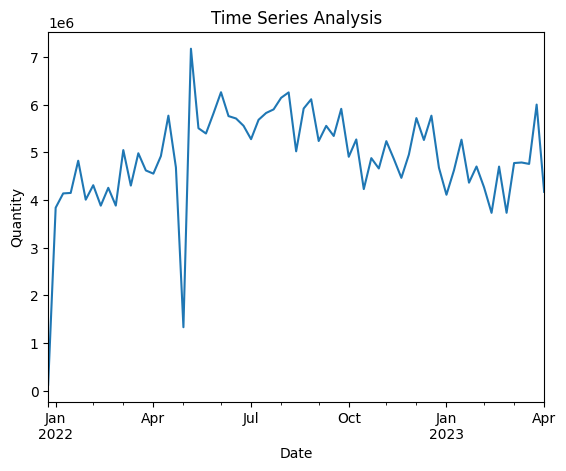

In [27]:
# Plot the time series data with index on y-axis
df2.plot(legend=None)
plt.ylabel('Quantity')
plt.xlabel('Date')
plt.title('Time Series Analysis')
plt.show()

In [28]:
df2

,quantity
week_start_date,
2021-12-27,128808
2022-01-03,3839557
2022-01-10,4138934
2022-01-17,4149077
2022-01-24,4824273
...,...
2023-03-06,4775638
2023-03-13,4787111
2023-03-20,4757590


Setting frequency of dataframe to weekly to visualize ACF plots and seasonal decomposition.

In [29]:
df2.index.freq = 'W-MON'

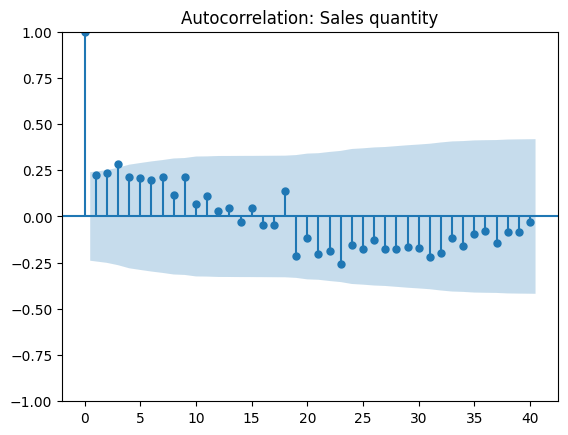

In [30]:
title = 'Autocorrelation: Sales quantity'
lags = 40
plot_acf(df2['quantity'],title=title,lags=lags);

**Observation:** ACF plots shows that there is almost no relation of current quantity sales with previous quantity sales. 

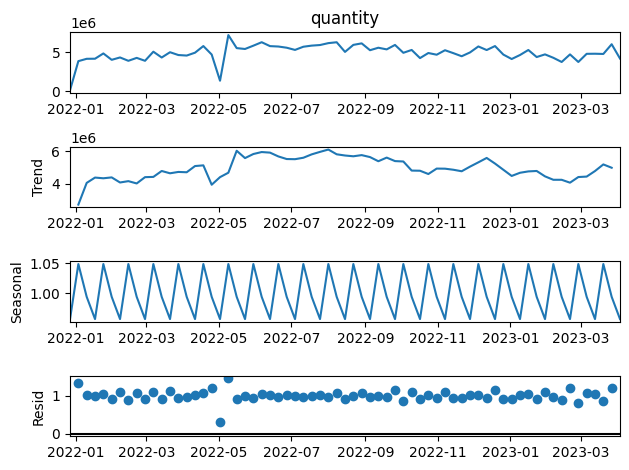

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df2['quantity'].fillna(df2['quantity'].mean()), model='mul', period=3)
result.plot();

**Observation:**  In the seasonal decomposition, it can be seen that the `seasonality component is too small to be considered`. There is also `a little  indication trend.`

### F. Feature Engineering

**1. Feature Creation**

I did not add `day` values for feature creation because our data has been grouped by the week and adding day data will miss intepret. The following features will be created in the dataset:
1. Product wise sales quantity (only those products that were sold every week)
2. Last 4 total sales quantity
3. quarter, month, year, and week of the year

**A. Product wise sales quantity**

Grouping the original DataFrame df1 by 'week_start_date' and 'product_item' columns, and aggregating the 'quantity' column by sum

In [32]:
# group by week_number and product_item and sum the quantity column
df_sales = df1.groupby(['week_start_date', 'product_item']).agg({'quantity': 'sum'}).reset_index()

Pivoting the df_sales DataFrame to create a new DataFrame df_pivot with each product item as a column and the total sales for each week as the values:

In [33]:
df_pivot = df_sales.pivot(index='week_start_date', columns='product_item', values='quantity').reset_index()

Creating a list of product items and merging it with another DataFrame df2:

In [34]:
products = df1['product_item'].value_counts()

In [35]:
df3 = pd.merge(df_pivot[list(products[products==67].index.values)+['week_start_date']], df2, right_index=True, left_on='week_start_date')
df3.set_index('week_start_date', drop=True, inplace=True)

This creates a new DataFrame df by merging the df_pivot DataFrame with df2 DataFrame using the 'week_start_date' column as the key. 

It selects only the columns corresponding to the product items that have a count of 67 in the original df1 DataFrame, and includes the 'week_start_date' column.

**B. Creating lag values**

In [36]:
# Shifting the target (quantity) up by 1 so it becomes target (to be predicted) for all the columns
df3['quantity'] = df3['quantity'].shift(-1)

df3.index.freq = 'W-MON'  # Setting frequency to weekly

## Last 4 total sales quantity features
for i in range(1, 5):
  df3[f'last {i} quantity'] = df3['quantity'].shift(i, fill_value=df3['quantity'].iloc[0])

**C. Adding time element features**

In [37]:
df3['quarter'] = df3.index.quarter
df3['month'] = df3.index.month
df3['year'] = df3.index.year
df3['weekofyear'] = df3.index.isocalendar().week.astype(int)

In [38]:
# Storing last row before dropping to predict value for May
last_row = df3.iloc[-1]
df3.drop(df3.index[-1], inplace=True)  # Dropping last value because of shifting target variable

**2. Visualize our Feature (month) / Target Relationship**

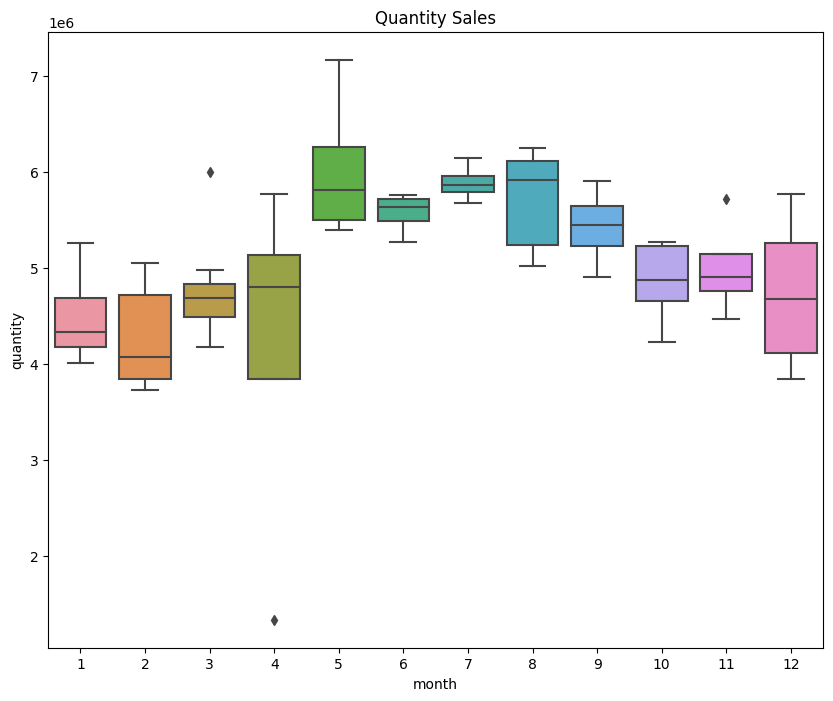

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df3, x='month', y='quantity')
ax.set_title('Quantity Sales')
plt.show()

### G. Train and Test Split ➗

We will split our train and test split with the following ration = ` 80 Train :20 Test`

**Note:** I will use `.iloc[:54]` because 54 is 80% of the total dataset (which has 67 rows).

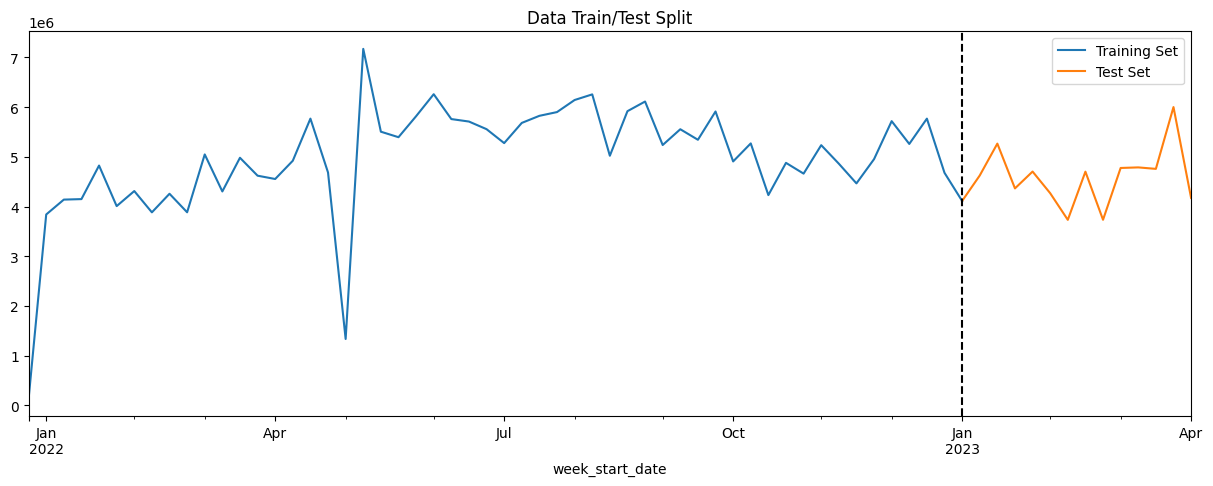

In [40]:
# Create a train/test split using .iloc [FOR VISUALIZATION]
train = df2.iloc[:54]  # Select first 54 rows as training set
test = df2.iloc[53:]   # Select remaining rows as test set

# Create the plot
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')

# Add vertical black line to separate train and test sets
ax.axvline(x=train.index[-1], color='black', linestyle='--')

ax.legend(['Training Set', 'Test Set'])
plt.show()

# Create a train/test split using .iloc [WITH NEW FEATURES]
train = df3.iloc[:54]  # Select first 54 rows as training set
test = df3.iloc[53:]   # Select remaining rows as test set


**Note:**

The reason is that when you use df2.iloc[54:] as the test set, it starts from the 55th row (index 54) onwards, which means it does not include the 54th row. 

On the other hand, if you use df2.iloc[53:] as the test set, it starts from the 54th row (index 53) onwards, including the 54th row. This ensures that the line chart is connected between the last data point of the training set

### H. Model Selection and Model Definition

**1. Chosen Models**

1. Baseline Models ✅

  a. `Exponential Smoothing models:` Exponential Smoothing models are a family of statistical models for time series forecasting that capture both trend and seasonality in the data. 



---



2. Complex Models ✅

  a. `ARIMA (AutoRegressive Integrated Moving Average)` ARIMA is a relatively simple model and can be a good choice for stationary data without seasonality or trend.

  b. `Gradient Boosting Models (e.g., XGBoost, LightGBM, CatBoost):` Gradient boosting models are powerful machine learning algorithms that can be used for time series forecasting. These models can capture complex patterns in the data and are known for their accuracy and ability to handle large datasets.



**I. Defining Features and Target**

In [41]:
X_train = train.drop('quantity', axis=1)
y_train = train['quantity']

X_test = test.drop('quantity', axis=1)
y_test = test['quantity']

**2. Model Assumptions**

Checking the stationarity of the data using the dickey fuller test. If the p-value comes below 0.05 then, it is assumed that the data is stationary.

In [42]:
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")   

In [43]:
check_stationarity(train['quantity'])

ADF Statistic: -5.831886
p-value: 0.000000
Critical Values:
	1%: -3.560
	5%: -2.918
	10%: -2.597
Stationary


**Observation:**
A negative ADF test statistic with a p-value close to zero and lower than the significance level (commonly set at 0.05) indicates that the time series data is likely stationary, which means it does not have a trend or seasonality.

**2. Model Evaluation Metrics**

Evaluation metric for evaluation of the models is chosen to be root mean squared error. This metric is often used because it penalises the predictions that have too much error. 

This is what is required in forecasting for sales as we would need to forecast all the values with fair bit of accuracy.

### I. Model Training and Evaluation



**(I) Exponential smoothing**
<br>Here three models are applied on the dataset and their rmse values are computed:
1. Exponential smoothing
2. Holt's method with additive model 
3. Holt-winter's method with additive model
<br>Additive model makes sense as the trend appears to be linear

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


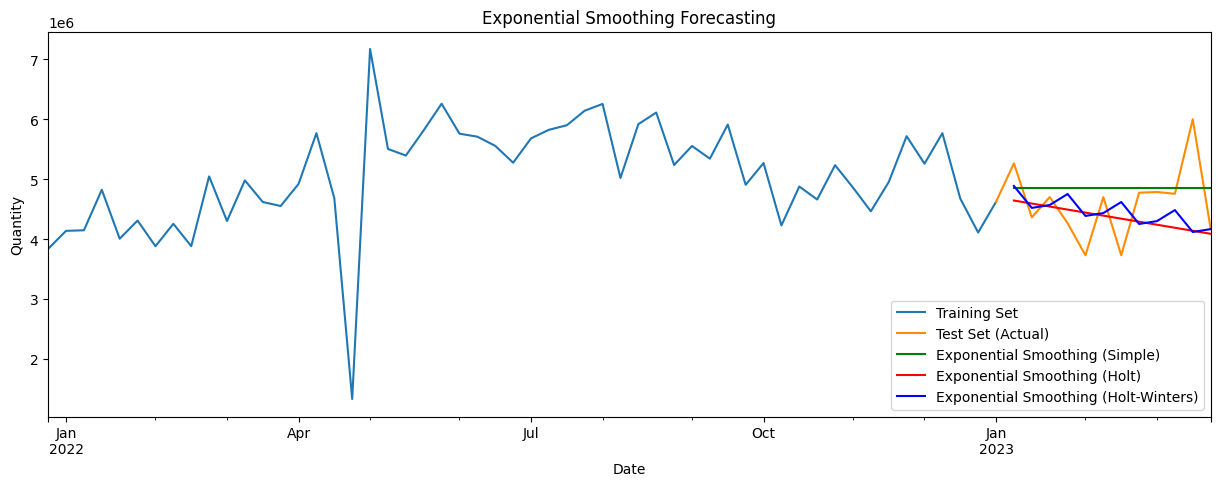

Root mean squared errors:
Exponential smoothing (simple) rmse: 653973.6343983319
Exponential smoothing (Holt's method) rmse: 695770.2706465716
Exponential smoothing (Hol-winter's method) rmse: 696924.9853318369
Mean Absolute Percentage Errors:
Exponential smoothing (simple) MAPE: 0.10511757013539959
Exponential smoothing (Holt's method) MAPE: 0.12381048329108564
Exponential smoothing (Holt-Winters' method) MAPE: 0.11651727276508028


In [44]:
### Exponential Smoothing Models

#######################################################
## Exponential Smoothing (Simple Exponential Smoothing)
#######################################################
# Fit the model
model_ses = ExponentialSmoothing(train['quantity'], trend=None, seasonal=None)
model_ses_fit = model_ses.fit()

# Predict on test set
test_pred_ses = model_ses_fit.forecast(len(test)-1)

# Create a copy of the test set DataFrame
test_pred_df_ses = test.copy()

# Set predicted values for Simple Exponential Smoothing
test_pred_df_ses['Exponential Smoothing (Simple)'] = test_pred_ses

########################################
## Exponential Smoothing (Holt's Method)
########################################
# Fit the model
model_holt = ExponentialSmoothing(train['quantity'], trend='add', seasonal=None)
model_holt_fit = model_holt.fit()

# Predict on test set
test_pred_holt = model_holt_fit.forecast(len(test)-1)

# Create a copy of the test set DataFrame
test_pred_df_holt = test.copy()

# Set predicted values for Holt's Method
test_pred_df_holt['Exponential Smoothing (Holt)'] = test_pred_holt

###############################################
## Exponential Smoothing (Holt-Winters' Method)
###############################################
# Fit the model
model_hw = ExponentialSmoothing(train['quantity'], trend='add', seasonal='add', seasonal_periods=3)
model_hw_fit = model_hw.fit()

# Predict on test set
test_pred_hw = model_hw_fit.forecast(len(test)-1)

# Create a copy of the test set DataFrame
test_pred_df_hw = test.copy()

# Set predicted values for Holt-Winters' Method
test_pred_df_hw['Exponential Smoothing (Holt-Winters)'] = test_pred_hw


## Plotting
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the training set
train['quantity'].plot(ax=ax, label='Training Set')

# Plot the original test set
test['quantity'].plot(ax=ax, label='Test Set (Actual)', color='darkorange')

# Plot the Exponential Smoothing (Simple) predicted values
test_pred_ses.plot(ax=ax, y='Exponential Smoothing (Simple)', label='Exponential Smoothing (Simple)', color='green')

# Plot the Exponential Smoothing (Holt) predicted values
test_pred_holt.plot(ax=ax, y='Exponential Smoothing (Holt)', label='Exponential Smoothing (Holt)', color='red')

# Plot the Exponential Smoothing (Holt-Winters) predicted values
test_pred_hw.plot(ax=ax, y='Exponential Smoothing (Holt-Winters)', label='Exponential Smoothing (Holt-Winters)', color='blue')

# Set plot title and labels
ax.set_title('Exponential Smoothing Forecasting')
ax.set_xlabel('Date')
ax.set_ylabel('Quantity')
plt.legend()
plt.show()

## Model evaluation
expon_smooth_rmse = rmse(test_pred_df_ses['Exponential Smoothing (Simple)'].iloc[1:], y_test.iloc[1:])
expon_holt_rmse = rmse(test_pred_df_holt['Exponential Smoothing (Holt)'].iloc[1:], y_test.iloc[1:])
expon_hw_rmse = rmse(test_pred_df_hw['Exponential Smoothing (Holt-Winters)'].iloc[1:], y_test.iloc[1:])
print("Root mean squared errors:")
print("Exponential smoothing (simple) rmse:", expon_smooth_rmse)
print("Exponential smoothing (Holt's method) rmse:", expon_holt_rmse)
print("Exponential smoothing (Hol-winter's method) rmse:", expon_hw_rmse)

expon_smooth_mape = mape(test_pred_df_ses['Exponential Smoothing (Simple)'].iloc[1:], y_test.iloc[1:])
expon_holt_mape = mape(test_pred_df_holt['Exponential Smoothing (Holt)'].iloc[1:], y_test.iloc[1:])
expon_hw_mape = mape(test_pred_df_hw['Exponential Smoothing (Holt-Winters)'].iloc[1:], y_test.iloc[1:])
print("Mean Absolute Percentage Errors:")
print("Exponential smoothing (simple) MAPE:", expon_smooth_mape)
print("Exponential smoothing (Holt's method) MAPE:", expon_holt_mape)
print("Exponential smoothing (Holt-Winters' method) MAPE:", expon_hw_mape)

**(II) ARIMA (AutoRegressive Integrated Moving Average)**

Running arima model with random p,d,q parameters.

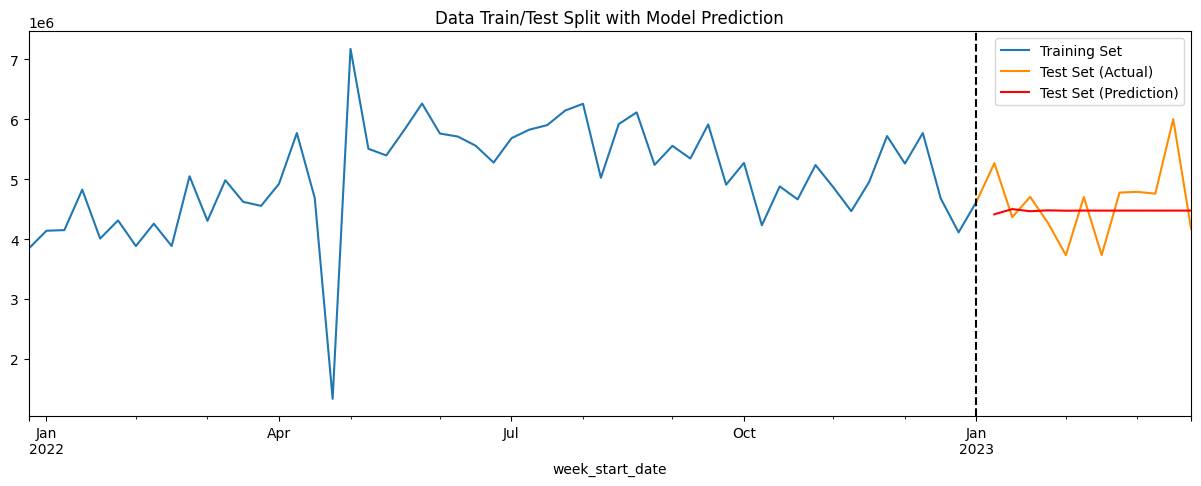

ARIMA RMSE: 624997.1704021473
ARIMA MAPE: 0.10958607957113449


In [45]:
## Create ARIMA model
model = ARIMA(train['quantity'], order=(1, 1, 0))  #random 3 values pdq
model_fit = model.fit()

# Make predictions on the test set
test_pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 2)

# Create a copy of the test set DataFrame
test_pred_df = test.copy()

# Add the predicted values as a new column to the DataFrame
test_pred_df['ARIMA Prediction'] = test_pred

# Create the plot
fig, ax = plt.subplots(figsize=(15, 5))
train['quantity'].plot(ax=ax, label='Training Set', title='Data Train/Test Split with Model Prediction')
test['quantity'].plot(ax=ax, label='Test Set (Actual)', color='darkorange')  # Add the original test set with custom label
test_pred.plot(ax=ax, y='ARIMA Prediction', label='Test Set (Prediction)', color='red')  # Plot the predicted values with custom label and color

# Add vertical black line to separate train and test sets
ax.axvline(x=train.index[-1], color='black', linestyle='--')

ax.legend(['Training Set', 'Test Set (Actual)', 'Test Set (Prediction)'])  # Update the legend labels
plt.show()


# Calculate RMSE for ARIMA forecast
arima_rmse = rmse(test_pred_df['ARIMA Prediction'].iloc[1:], y_test.iloc[1:])

# Calculate MAPE for ARIMA forecast
arima_mape = mape(test_pred_df['ARIMA Prediction'].iloc[1:], y_test.iloc[1:])

print("ARIMA RMSE:", arima_rmse)
print("ARIMA MAPE:", arima_mape)

This code block will determine the best p,d,q values for the ARIMA model

In [46]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Function to find the best ARIMA order
def find_best_arima_order(train_data, max_order=(5, 2, 5)):
    best_rmse = float('inf')
    best_order = None

    # Loop through possible parameter values for ARIMA
    for p in range(max_order[0] + 1):
        for d in range(max_order[1] + 1):
            for q in range(max_order[2] + 1):
                try:
                    model = ARIMA(train_data, order=(p, d, q))
                    results = model.fit(method_kwargs={'warn_convergence': False})
                    # Calculate RMSE
                    y_pred = results.predict(start=len(train_data), end=len(train_data) + len(y_test) - 1)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_order = (p, d, q)
                except:
                    continue

    return best_order, best_rmse

# Find the best ARIMA order
best_order, best_rmse = find_best_arima_order(y_train)

print("Best ARIMA Order (p, d, q):", best_order)
print("Best RMSE:", best_rmse)

Best ARIMA Order (p, d, q): (5, 1, 3)
Best RMSE: 571504.6632230756


Running the ARIMA model with the best parameters (p,d,q) of (5,1,3)

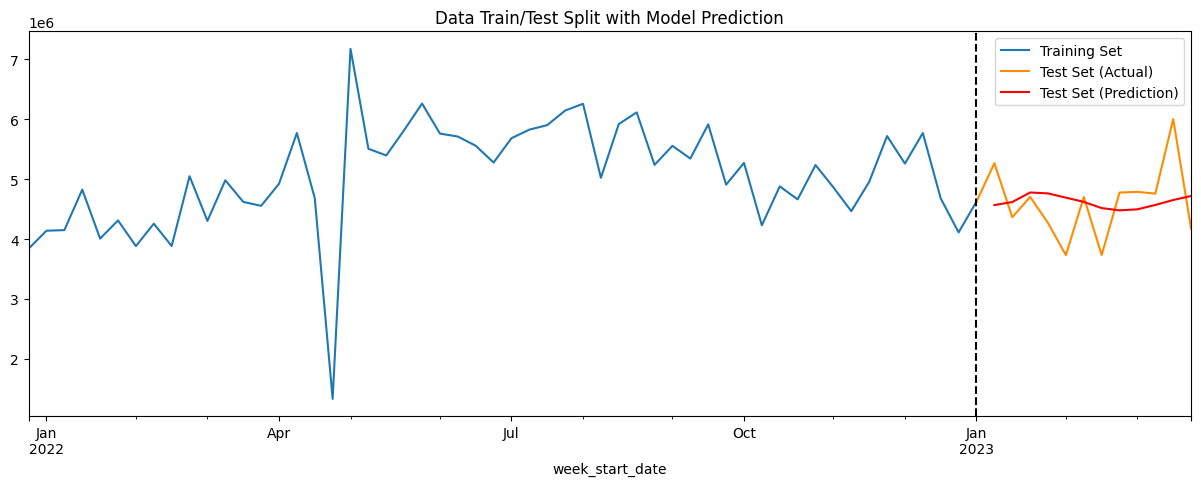

ARIMA RMSE: 623891.7481362197
ARIMA MAPE: 0.10840095138333321


In [47]:
# Create ARIMA model
model = ARIMA(train['quantity'], order=(5, 1, 3))  #random 3 values pdq
model_fit = model.fit()

# Make predictions on the test set
test_pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 2)

# # Create a copy of the test set DataFrame
# test_pred_df = test.copy()

# Add the predicted values as a new column to the DataFrame
test_pred_df['ARIMA Prediction'] = test_pred

# Create the plot
fig, ax = plt.subplots(figsize=(15, 5))
train['quantity'].plot(ax=ax, label='Training Set', title='Data Train/Test Split with Model Prediction')
test['quantity'].plot(ax=ax, label='Test Set (Actual)', color='darkorange')  # Add the original test set with custom label
test_pred.plot(ax=ax, y='ARIMA Prediction', label='Test Set (Prediction)', color='red')  # Plot the predicted values with custom label and color

# Add vertical black line to separate train and test sets
ax.axvline(x=train.index[-1], color='black', linestyle='--')

ax.legend(['Training Set', 'Test Set (Actual)', 'Test Set (Prediction)'])  # Update the legend labels
plt.show()

# Calculate RMSE for ARIMA forecast
arima_rmse = rmse(test_pred_df['ARIMA Prediction'].iloc[1:], y_test.iloc[1:])

# Calculate MAPE for ARIMA forecast
arima_mape = mape(test_pred_df['ARIMA Prediction'].iloc[1:], y_test.iloc[1:])

print("ARIMA RMSE:", arima_rmse)
print("ARIMA MAPE:", arima_mape)

**(III) Gradient Boosting Models with XGBoost**
<br> Here all the features created are used for the ML model

[14:20:41] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


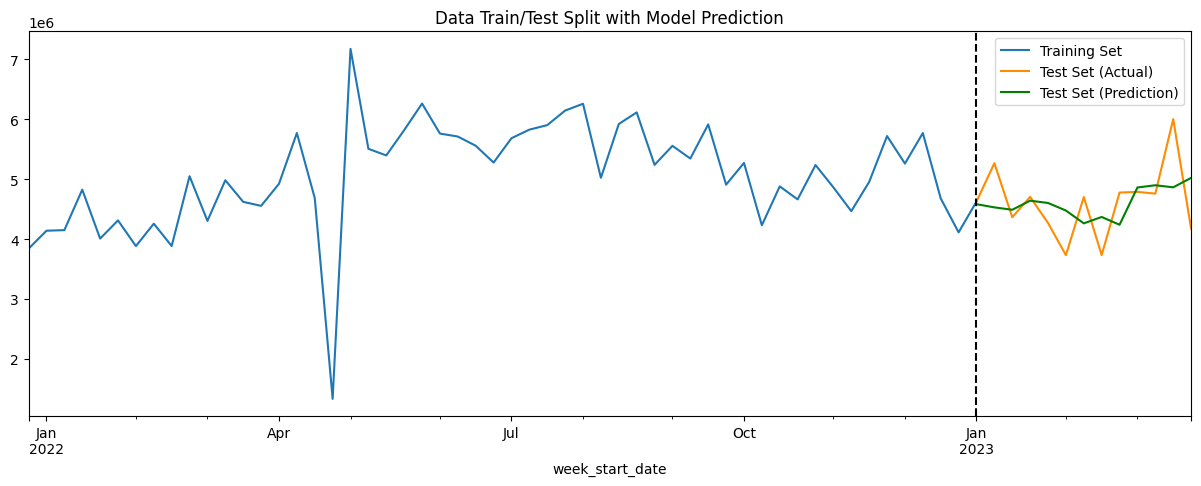

XGBoost RMSE: 565402.7970792151
XGBoost MAPE: 0.09802057558339908


In [48]:
import matplotlib.pyplot as plt
import xgboost as xgb

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=200,
                       objective='reg:linear',
                       max_depth=2,
                       learning_rate=0.02)
reg.fit(X_train, y_train)

# Make predictions on the test set
test_pred = reg.predict(X_test)


# Create a copy of the test set DataFrame
test_pred_df = test.copy()

# Add the predicted values as a new column to the DataFrame
test_pred_df['XGB Boost Prediction'] = test_pred

# Create the plot
fig, ax = plt.subplots(figsize=(15, 5))
train['quantity'].plot(ax=ax, label='Training Set', title='Data Train/Test Split with Model Prediction')
test['quantity'].plot(ax=ax, label='Test Set (Actual)', color='darkorange')  # Add the original test set with custom label
test_pred_df.plot(ax=ax, y='XGB Boost Prediction', label='Test Set (Prediction)', color='green')  # Plot the predicted values with custom label and color

# Add vertical black line to separate train and test sets
ax.axvline(x=train.index[-1], color='black', linestyle='--')

ax.legend(['Training Set', 'Test Set (Actual)', 'Test Set (Prediction)'])  # Update the legend labels
plt.show()

# Calculate RMSE for XGBoost forecast
xgboost_rmse = rmse(test_pred_df['XGB Boost Prediction'], y_test)

# Calculate MAPE for XGBoost forecast
xgboost_mape = mape(test_pred_df['XGB Boost Prediction'], y_test)

print("XGBoost RMSE:", xgboost_rmse)
print("XGBoost MAPE:", xgboost_mape)

**(IV) Visualizing top 10 important features for xgboost model**
<br>The ML model determines which features were the most important in predicting the result for xgboost model. The following code shows the top 10 features that were more important in the predictions.

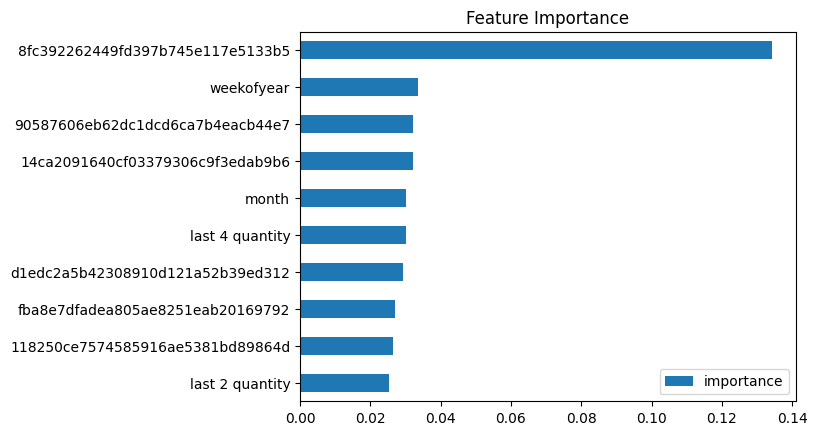

In [49]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').tail(10).plot(kind='barh', title='Feature Importance')
plt.show()

## 4. Conclusion and Overall Analysis 🔖


In [50]:
print("Exponential smoothening Holt method rmse:", expon_holt_rmse)
print("Exponential smoothening Holt method mape:", expon_holt_mape)

print("Holt winters method rmse:", expon_hw_rmse)
print("Holt winters method mape:", expon_hw_mape)

print("ARIMA method rmse:", arima_rmse)
print("ARIMA method mape:", arima_mape)

print('xgboost rmse:', xgboost_rmse)
print('xgboost mape:', xgboost_mape)

Exponential smoothening Holt method rmse: 695770.2706465716
Exponential smoothening Holt method mape: 0.12381048329108564
Holt winters method rmse: 696924.9853318369
Holt winters method mape: 0.11651727276508028
ARIMA method rmse: 623891.7481362197
ARIMA method mape: 0.10840095138333321
xgboost rmse: 565402.7970792151
xgboost mape: 0.09802057558339908


With the above rmse values, it is evident that the `xgboost regressor has the best performance`. This makes sense as the dataset has very few instances to train on.There is also almost no seasonality component in the dataset.



---



**1. Why did XGBoost performed better than other models?**

The performance of the statistical based forecasting methods like exponential smoothing and ARIMA models have more or less the same performance. This is because there is not much predictability if we consider only the single time series of total sales quantity. However, if we include the individual product sales quantity (like we have done in xgb regressor) as features, the predictions are better as the total sales quantity may have a relation with the individual products sales quantity. 

- XGBoost is capable of capturing complex non-linear relationships in the data, while ARIMA assumes linear relationships between variables.
- XGBoost can handle larger datasets with a large number of features, while ARIMA may struggle with computational limitations.
- XGBoost allows for the incorporation of external features, while ARIMA relies only on the historical values of the time series itself.



---



**2. Why I did not use SARIMA or ARIMAX**

Sarima only introduces a seasonal component in arima. As we have established there is not seasonality so, we don't use it. 

I think ARIMAX is exogenous variable based where there is a variable that we know will impact the sales in future beforehand, like a holiday or something. I have never used it. There was no variable like that here.



---



**3. Overall Analyis**

The performance of the xgb regressor is more or less around 550000 rmse value. If we compare it with average value of the dataset which is around 5,000,000, it is at `10% error level`.



**Predictions for May 2023**
<br>The following code shows the predictions for May

In [51]:
print("Exponential smoothing holt's method:", model_holt_fit.forecast(len(test))[-1])
print("Exponential smoothing holt-winter's method:", model_hw_fit.forecast(len(test))[-1])
print("ARIMA model:", model_fit.predict(start=len(train), end=len(train) + len(test) - 1)[-1])
print("xgb regressor prediction: ", reg.predict(pd.DataFrame(last_row).T.drop('quantity',axis=1))[0])

Exponential smoothing holt's method: 4039520.043014064
Exponential smoothing holt-winter's method: 4352182.972102297
ARIMA model: 4727257.588039281
xgb regressor prediction:  4804693.0


**Train evaluation score**
<br>The following code shows rmse for training data for each model

RMSE for training data
Exp smoothing (holt's): 818174.9328707943
holt-winters: 804440.030921056
ARIMA model: 1038558.4023134634
XGBRegressor: 260413.38506418146


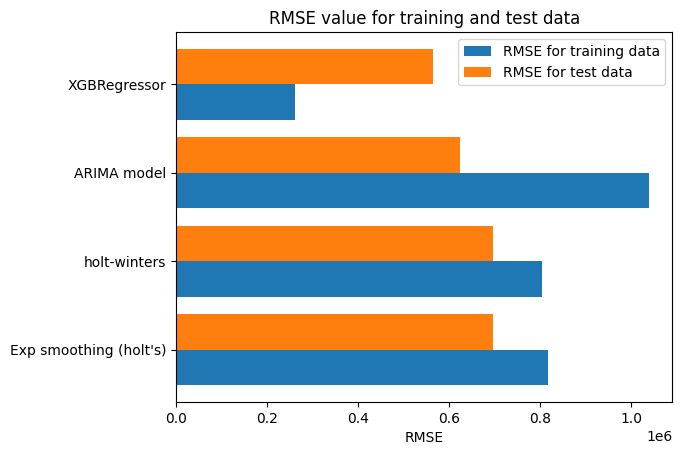

In [52]:
print('RMSE for training data')
print("Exp smoothing (holt's):",rmse(model_holt_fit.predict(start = 0, end = len(train)-1), y_train))
print("holt-winters:",rmse(model_hw_fit.predict(start = 0, end = len(train)-1), y_train))
print("ARIMA model:",rmse(model_fit.predict(start = 0, end = len(train)-1), y_train))
print('XGBRegressor:', rmse(reg.predict(X_train), y_train))
X = ["Exp smoothing (holt's)", "holt-winters", "ARIMA model", 'XGBRegressor']
train_rmse = [
    rmse(model_holt_fit.predict(start = 0, end = len(train)-1), y_train),
    rmse(model_hw_fit.predict(start = 0, end = len(train)-1), y_train),
    rmse(model_fit.predict(start = 0, end = len(train)-1), y_train),
    rmse(reg.predict(X_train), y_train)
]
test_rmse = [expon_holt_rmse,expon_hw_rmse, arima_rmse, xgboost_rmse]

X_axis = np.arange(len(X))
  
plt.barh(X_axis - 0.2, train_rmse, 0.4, label = 'RMSE for training data')
plt.barh(X_axis + 0.2, test_rmse, 0.4, label = 'RMSE for test data')
  
plt.yticks(X_axis, X)
plt.xlabel("RMSE")
plt.title("RMSE value for training and test data")
plt.legend()
plt.show()

Comparing the rmse scores of models on training data, it can be seen that the Exponential smoothing models are underfitting since their rmse for test are lower than their rmse for training data. On the contrary, the xgb regressor model is overfitting with its rmse (around 260,000) lower than its rmse on test data (around 550,000).

## 5. Saving the model 🛒


In [53]:
# Save the model
reg.save_model("xgb_model.bin")